### Import library

In [1]:
import os
import numpy as np
import glob
import PIL.Image as Image

# pip install torchsummary
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import models
from torchsummary import summary
import torch.optim as optim
from time import time
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
from IPython.display import clear_output
from sklearn.model_selection import train_test_split

### Design the dataloader

In [2]:
class DRIVEDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        """
        Args:
            image_paths (list): List of file paths for images.
            mask_paths (list): List of file paths for masks.
            transform (callable, optional): Transformations for data augmentation.
        """
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Get the paths for the image and corresponding mask
        img_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]

        # Open the image and mask
        image = Image.open(img_path).convert("RGB")  # Ensure image is in RGB format
        mask = Image.open(mask_path).convert("L")  # Mask is a single-channel image

        # Apply transformations if any
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        return image, mask


In [3]:
image_dir = "/dtu/datasets1/02516/DRIVE/training/images/"
mask_dir = "/dtu/datasets1/02516/DRIVE/training/1st_manual/"

# Get the directory of image and mask, make sure they are in order.
image_paths = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir)])
mask_paths = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir)])

# Divide the dataset into train,val,test = 6:2:2
train_images, test_images, train_masks, test_masks = train_test_split(image_paths, mask_paths, test_size=0.2, random_state=42)
train_images, val_images, train_masks, val_masks = train_test_split(train_images, train_masks, test_size=0.25, random_state=42)


# Transform
transform = transforms.Compose([
    transforms.Resize((512, 512)),  # Resize the image and mask to the same size
    transforms.ToTensor(),          # Convert to tensor
])

In [4]:
image_dir_augmented ="/zhome/21/8/202236/RAI/DRIVE_train/images/"
mask_dir_aumented ="/zhome/21/8/202236/RAI/DRIVE_train/labels/"
image_paths_aug = sorted([os.path.join(image_dir_augmented, f) for f in os.listdir(image_dir_augmented)])
mask_paths_aug = sorted([os.path.join(mask_dir_aumented, f) for f in os.listdir(mask_dir_aumented)])


In [5]:
# Create Dataset Instance
train_dataset = DRIVEDataset(train_images, train_masks, transform=transform)
val_dataset = DRIVEDataset(val_images, val_masks, transform=transform)
test_dataset = DRIVEDataset(test_images, test_masks, transform=transform)

aug_train_dataset = DRIVEDataset(image_paths_aug, mask_paths_aug, transform=transform)

In [6]:
batch_size = 12
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,num_workers=2)

aug_train_loader = DataLoader(aug_train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

In [7]:
for batch_idx, (images, masks) in enumerate(train_loader):
    print(f"Batch {batch_idx + 1}:")
    print(f"Images shape: {images.shape}")
    print(f"Masks shape: {masks.shape}")

Batch 1:
Images shape: torch.Size([12, 3, 512, 512])
Masks shape: torch.Size([12, 1, 512, 512])


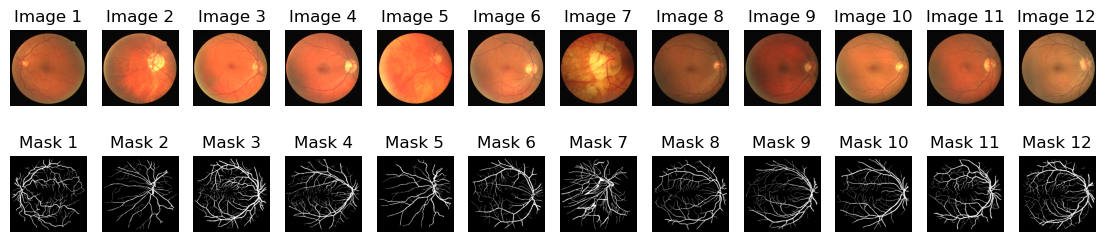

In [8]:
fig, axes = plt.subplots(2, 12, figsize=(14, 3))
for i in range(12):
    # display images
    axes[0, i].imshow(images[i].permute(1, 2, 0))  # Changes the order of dimensions from (C,H,W) to (H,W,C)
    axes[0, i].set_title(f"Image {i + 1}")
    axes[0, i].axis("off")
    
    # display masks
    axes[1, i].imshow(masks[i].squeeze(), cmap="gray")  # mask channel = 1
    axes[1, i].set_title(f"Mask {i + 1}")
    axes[1, i].axis("off")
    

In [9]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


### Metrics for performance

In [10]:
def dice_coefficient(pred, target, epsilon=1e-6):
    pred = (pred > 0.5).float()
    target = (target > 0.5).float()

    intersection = (pred * target).sum()
    union = pred.sum() + target.sum()
    dice = (2. * intersection + epsilon) / (union + epsilon)
    return dice

def iou(pred, target, epsilon=1e-6):
    pred = (pred > 0.5).float()
    target = (target > 0.5).float()

    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    iou = (intersection + epsilon) / (union + epsilon)
    return iou

def accuracy(pred, target):
    pred = (pred > 0.5).float()
    target = (target > 0.5).float()

    correct = (pred == target).sum()
    total = target.numel()
    return correct.float() / total

def sensitivity(pred, target, epsilon=1e-6):
    pred = (pred > 0.5).float()
    target = (target > 0.5).float()

    TP = ((pred == 1) & (target == 1)).sum()
    FN = ((pred == 0) & (target == 1)).sum()
    return TP.float() / (TP + FN + epsilon)

def specificity(pred, target, epsilon=1e-6):
    pred = (pred > 0.5).float()
    target = (target > 0.5).float()

    TN = ((pred == 0) & (target == 0)).sum()
    FP = ((pred == 1) & (target == 0)).sum()
    return TN.float() / (TN + FP + epsilon)


### Design Architecture(EncDec, UNet)

In [11]:
class EncDec(nn.Module):
    def __init__(self):
        super().__init__()

        # Encoder (downsampling)
        self.enc_conv0 = nn.Conv2d(3, 32, 3, padding=1)  
        self.pool0 = nn.MaxPool2d(2, 2)  # 512 -> 256
        self.enc_conv1 = nn.Conv2d(32, 64, 3, padding=1) 
        self.pool1 = nn.MaxPool2d(2, 2)  # 256 -> 128
        self.enc_conv2 = nn.Conv2d(64, 128, 3, padding=1)  
        self.pool2 = nn.MaxPool2d(2, 2)  # 128 -> 64
        self.enc_conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)  # 64 -> 32

        # Bottleneck
        self.bottleneck_conv = nn.Conv2d(256, 512, 3, padding=1) 

        # Decoder (upsampling)
        self.up_conv0 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)  # 32 -> 64
        self.dec_conv0 = nn.Conv2d(256, 256, 3, padding=1)
        
        self.up_conv1 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)  # 64 -> 128
        self.dec_conv1 = nn.Conv2d(128, 128, 3, padding=1)
        
        self.up_conv2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)  # 128 -> 256
        self.dec_conv2 = nn.Conv2d(64, 64, 3, padding=1)
        
        self.up_conv3 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)  # 256 -> 512
        self.dec_conv3 = nn.Conv2d(32, 32, 3, padding=1)
        
        # Final output layer
        self.final_conv = nn.Conv2d(32, 1, 1)  # 1x1 conv layer for final output

    def forward(self, x):
        # Encoder
        e0 = F.relu(self.enc_conv0(x))  # 512 -> 512
        e0_p = self.pool0(e0)  # Pooling: 512 -> 256

        e1 = F.relu(self.enc_conv1(e0_p))  # 256 -> 256
        e1_p = self.pool1(e1)  # Pooling: 256 -> 128

        e2 = F.relu(self.enc_conv2(e1_p))  # 128 -> 128
        e2_p = self.pool2(e2)  # Pooling: 128 -> 64

        e3 = F.relu(self.enc_conv3(e2_p))  # 64 -> 64
        e3_p = self.pool3(e3)  # Pooling: 64 -> 32

        # Bottleneck
        b = F.relu(self.bottleneck_conv(e3_p))  # 32 -> 32

        # Decoder
        d0 = F.relu(self.dec_conv0(self.up_conv0(b)))  # 32 -> 64
        d1 = F.relu(self.dec_conv1(self.up_conv1(d0)))  # 64 -> 128
        d2 = F.relu(self.dec_conv2(self.up_conv2(d1)))  # 128 -> 256
        d3 = F.relu(self.dec_conv3(self.up_conv3(d2)))  # 256 -> 512

        # Final output
        output = self.final_conv(d3)  # 512 -> 512 -> 1 channel output

        # Add sigmoid to output for binary classification
        output = torch.sigmoid(output) 
        return output

In [12]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        # Encoder (downsampling)
        self.enc_conv0 = nn.Conv2d(3, 16, 3, padding=1)  # Input: (512, 512) -> (512, 512) with 16 channels
        self.pool0 = nn.MaxPool2d(2, 2)  # 512 -> 256

        self.enc_conv1 = nn.Conv2d(16, 32, 3, padding=1)  # 256 -> 256
        self.pool1 = nn.MaxPool2d(2, 2)  # 256 -> 128

        self.enc_conv2 = nn.Conv2d(32, 64, 3, padding=1)  # 128 -> 128
        self.pool2 = nn.MaxPool2d(2, 2)  # 128 -> 64

        self.enc_conv3 = nn.Conv2d(64, 128, 3, padding=1)  # 64 -> 64
        self.pool3 = nn.MaxPool2d(2, 2)  # 64 -> 32

        # Bottleneck
        self.bottleneck_conv = nn.Conv2d(128, 256, 3, padding=1)  # 32 -> 32

        # Decoder (upsampling + conv)
        self.up_conv0 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)  # 32 -> 64
        self.dec_conv0 = nn.Conv2d(256, 128, 3, padding=1)  # concatenated with enc_conv3

        self.up_conv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)  # 64 -> 128
        self.dec_conv1 = nn.Conv2d(128, 64, 3, padding=1)  # concatenated with enc_conv2

        self.up_conv2 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)  # 128 -> 256
        self.dec_conv2 = nn.Conv2d(64, 32, 3, padding=1)  # concatenated with enc_conv1

        self.up_conv3 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)  # 256 -> 512
        self.dec_conv3 = nn.Conv2d(32, 16, 3, padding=1)  # concatenated with enc_conv0

        # Final output layer
        self.final_conv = nn.Conv2d(16, 1, 1)  # 1x1 conv layer to output 1 channel for binary segmentation

    def forward(self, x):
        # Encoder
        e0 = F.relu(self.enc_conv0(x))  # 512 -> 512 with 16 channels
        e0_p = self.pool0(e0)  # Pooling: 512 -> 256

        e1 = F.relu(self.enc_conv1(e0_p))  # 256 -> 256 with 32 channels
        e1_p = self.pool1(e1)  # Pooling: 256 -> 128

        e2 = F.relu(self.enc_conv2(e1_p))  # 128 -> 128 with 64 channels
        e2_p = self.pool2(e2)  # Pooling: 128 -> 64

        e3 = F.relu(self.enc_conv3(e2_p))  # 64 -> 64 with 128 channels
        e3_p = self.pool3(e3)  # Pooling: 64 -> 32

        # Bottleneck
        b = F.relu(self.bottleneck_conv(e3_p))  # 32 -> 32 with 256 channels

        # Decoder with skip connections
        d0 = self.up_conv0(b)  # 32 -> 64 with 128 channels
        d0 = torch.cat([d0, e3], dim=1)  # Concatenate with encoder layer (e3)
        d0 = F.relu(self.dec_conv0(d0))  # 256 channels after concatenation

        d1 = self.up_conv1(d0)  # 64 -> 128 with 64 channels
        d1 = torch.cat([d1, e2], dim=1)  # Concatenate with encoder layer (e2)
        d1 = F.relu(self.dec_conv1(d1))  # 128 channels after concatenation

        d2 = self.up_conv2(d1)  # 128 -> 256 with 32 channels
        d2 = torch.cat([d2, e1], dim=1)  # Concatenate with encoder layer (e1)
        d2 = F.relu(self.dec_conv2(d2))  # 64 channels after concatenation

        d3 = self.up_conv3(d2)  # 256 -> 512 with 16 channels
        d3 = torch.cat([d3, e0], dim=1)  # Concatenate with encoder layer (e0)
        d3 = F.relu(self.dec_conv3(d3))  # 32 channels after concatenation

        # Final output layer (sigmoid can be applied in loss function for binary segmentation)
        output = self.final_conv(d3)  # 64 -> 1 channel for binary segmentation

        # Add sigmoid to output for binary classification
        output = torch.sigmoid(output)
        return output


### Loss func

In [13]:
def bce_loss(pred, target):
    bce_criterion = nn.BCELoss()
    loss = bce_criterion(pred, target)
    return loss

In [14]:
def focal_loss(y_pred, y_real, alpha=1, gamma=2):
    bce_loss = F.binary_cross_entropy(y_pred, y_real, reduction='none')
    pt = torch.where(y_real == 1, y_pred, 1 - y_pred)
    loss = alpha * (1 - pt) ** gamma * bce_loss
    return loss.mean()

### Train,validate model

In [15]:
import cv2

def apply_top_hat(img):
    # Assuming the input img is in numpy format (H, W)
    # Create a structuring element (adjust size as needed)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 15))
    # Apply the Top-Hat transformation
    top_hat_img = cv2.morphologyEx(img, cv2.MORPH_TOPHAT, kernel)
    return top_hat_img

def evaluate(model, loader, device, loss_fn, stage="Validation"):
    model.eval()
    dice_scores, iou_scores, acc_scores, sens_scores, spec_scores = [], [], [], [], []
    total_loss = 0
    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)

            loss = loss_fn(outputs, masks)  # Calculate loss
            total_loss += loss.item() / len(loader)
            
            preds = (outputs > 0.5).float()  # Assume a binary classification task, threshold at 0.5
            masks = (masks > 0.5).float()  # Assume a binary classification task, threshold at 0.5
            
            # Calculate performance metrics
            dice_scores.append(dice_coefficient(preds, masks).item())
            iou_scores.append(iou(preds, masks).item())
            acc_scores.append(accuracy(preds, masks).item())
            sens_scores.append(sensitivity(preds, masks).item())
            spec_scores.append(specificity(preds, masks).item())

    avg_dice = sum(dice_scores) / len(dice_scores)
    avg_iou = sum(iou_scores) / len(iou_scores)
    avg_acc = sum(acc_scores) / len(acc_scores)
    avg_sens = sum(sens_scores) / len(sens_scores)
    avg_spec = sum(spec_scores) / len(spec_scores)

    # Display predictions on the validation set
    X_val, Y_val = next(iter(loader))  # Extract a batch of data from the validation set
    X_val, Y_val = X_val.to(device), Y_val.to(device)
    Y_hat = model(X_val).detach().cpu()  # Perform prediction and move to CPU

    clear_output(wait=True)  # Clear previous output to avoid repetitive displays
    num_images_to_show = min(len(X_val), 6)  # Show up to 6 images

    plt.figure(figsize=(8, 10))  # Adjust image size, width=8, height=10, can be modified as needed
    for k in range(num_images_to_show):
        plt.subplot(5, num_images_to_show, k+1)  # Set up a 5-row grid
        plt.imshow(np.rollaxis(X_val[k].cpu().numpy(), 0, 3), cmap='gray')
        plt.title('Image')
        plt.axis('off')

        plt.subplot(5, num_images_to_show, k+num_images_to_show+1)
        # Use .squeeze() to remove single-channel dimension
        plt.imshow(Y_val[k].cpu().numpy().squeeze(), cmap='gray')
        plt.title('Mask')
        plt.axis('off')

        plt.subplot(5, num_images_to_show, k+num_images_to_show*2+1)
        # Display original prediction Y_hat
        plt.imshow(Y_hat[k].cpu().numpy().squeeze(), cmap='gray')
        plt.title('Predict')
        plt.axis('off')

        plt.subplot(5, num_images_to_show, k+num_images_to_show*3+1)
        # Apply Top-Hat transformation to the prediction Y_hat
        y_hat_image = Y_hat[k].cpu().numpy().squeeze()
        y_hat_top_hat = apply_top_hat(y_hat_image)  # Apply Top-Hat transformation
        plt.imshow(y_hat_top_hat, cmap='gray')
        plt.title('Top-Hat')
        plt.axis('off')

        plt.subplot(5, num_images_to_show, k+num_images_to_show*4+1)
        # Threshold the Top-Hat transformed image
        threshold = 0.06
        y_hat_binary = (y_hat_top_hat.squeeze() > threshold).astype(np.uint8)
        plt.imshow(y_hat_binary, cmap='gray')
        plt.title('Thresholding')
        plt.axis('off')

    # Adjust spacing between subplots
    plt.subplots_adjust(hspace=0.2)  # hspace adjusts row spacing, wspace adjusts column spacing
    plt.suptitle(f'{stage} Results - Loss: {total_loss:.4f}')
    plt.show()
    return total_loss, avg_dice, avg_iou, avg_acc, avg_sens, avg_spec

In [16]:
# 训练函数
def train(model, opt, loss_fn, epochs, train_loader, val_loader, device):
    model.to(device)  # 将模型移动到指定设备上
    
    # 记录每个 epoch 的训练损失和验证损失
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        print(f'* Epoch {epoch+1}/{epochs}')
        avg_loss = 0

        model.train()  # 模型设为训练模式
        for X_batch, Y_batch in train_loader:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            # 清除以前的梯度
            opt.zero_grad()

            # 前向传播
            Y_pred = model(X_batch)
            loss = loss_fn(Y_pred, Y_batch)  # 计算损失
            loss.backward()  # 反向传播
            opt.step()  # 更新模型权重
            avg_loss += loss.item() / len(train_loader)  # 累积损失

        train_losses.append(avg_loss)  # 记录当前 epoch 的训练损失
        print(f' - Training Loss: {avg_loss:.4f}')
        
        # 每 10 个 epoch 计算一次验证损失
        if epoch % 10 == 0:
            val_loss, val_dice, val_iou, val_acc, val_sens, val_spec= evaluate(model, val_loader, device, loss_fn, stage="Validation")
            val_losses.append(val_loss)  # 记录当前 epoch 的验证损失
            print(f"Validation: Loss: {val_loss:.4f}, Dice: {val_dice:.4f}, IoU: {val_iou:.4f}, Acc: {val_acc:.4f}, Sens: {val_sens:.4f}, Spec: {val_spec:.4f}")

    # 在训练结束后，绘制训练损失和验证损失的曲线
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(range(0, epochs, 10), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.show()

def validate(model, val_loader, device, loss_fn):
    val_loss, val_dice, val_iou, val_acc, val_sens, val_spec = evaluate(model, val_loader, device, loss_fn, stage="Validation")
    print(f"Validation: Loss: {val_loss:.4f}, Dice: {val_dice:.4f}, IoU: {val_iou:.4f}, Acc: {val_acc:.4f}, Sens: {val_sens:.4f}, Spec: {val_spec:.4f}")

# test 
def test(model, test_loader, device, loss_fn):
    # evaluate on the test set
    test_loss, test_dice, test_iou, test_acc, test_sens, test_spec = evaluate(model, test_loader, device, loss_fn, stage="Test")
    print(f"Test Results: Loss: {test_loss:.4f}, Dice: {test_dice:.4f}, IoU: {test_iou:.4f}, "
          f"Acc: {test_acc:.4f}, Sens: {test_sens:.4f}, Spec: {test_spec:.4f}")

### Initialize model

#### 1.EncDec, without augmentation epoch=550

In [31]:
model_EncDec = EncDec().to(device)
summary(model_EncDec, (3, 512, 512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 512, 512]             896
         MaxPool2d-2         [-1, 32, 256, 256]               0
            Conv2d-3         [-1, 64, 256, 256]          18,496
         MaxPool2d-4         [-1, 64, 128, 128]               0
            Conv2d-5        [-1, 128, 128, 128]          73,856
         MaxPool2d-6          [-1, 128, 64, 64]               0
            Conv2d-7          [-1, 256, 64, 64]         295,168
         MaxPool2d-8          [-1, 256, 32, 32]               0
            Conv2d-9          [-1, 512, 32, 32]       1,180,160
  ConvTranspose2d-10          [-1, 256, 64, 64]         524,544
           Conv2d-11          [-1, 256, 64, 64]         590,080
  ConvTranspose2d-12        [-1, 128, 128, 128]         131,200
           Conv2d-13        [-1, 128, 128, 128]         147,584
  ConvTranspose2d-14         [-1, 64, 2

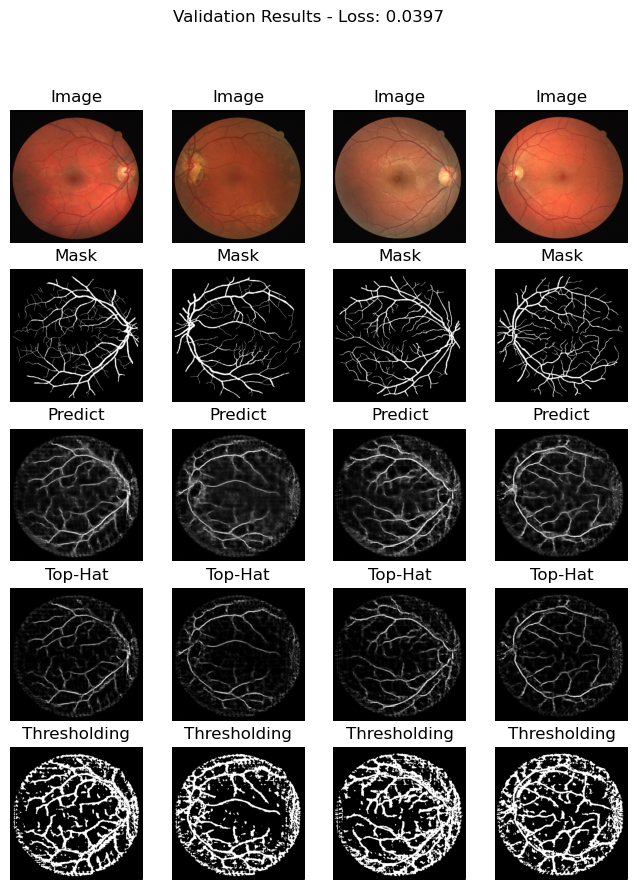

Validation: Loss: 0.0397, Dice: 0.4242, IoU: 0.2692, Acc: 0.9315, Sens: 0.2964, Spec: 0.9906
* Epoch 542/550
 - Training Loss: 0.0227
* Epoch 543/550
 - Training Loss: 0.0216
* Epoch 544/550
 - Training Loss: 0.0209
* Epoch 545/550
 - Training Loss: 0.0211
* Epoch 546/550
 - Training Loss: 0.0207
* Epoch 547/550
 - Training Loss: 0.0205
* Epoch 548/550
 - Training Loss: 0.0206
* Epoch 549/550
 - Training Loss: 0.0207
* Epoch 550/550
 - Training Loss: 0.0202


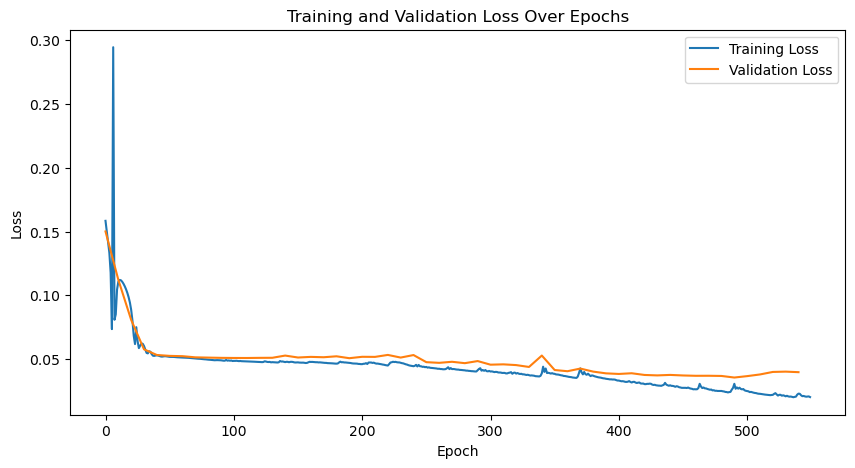

In [32]:
train(
    model=model_EncDec,
    opt=optim.Adam(model_EncDec.parameters(), lr=0.001),
    loss_fn=focal_loss,
    epochs=550,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device
)

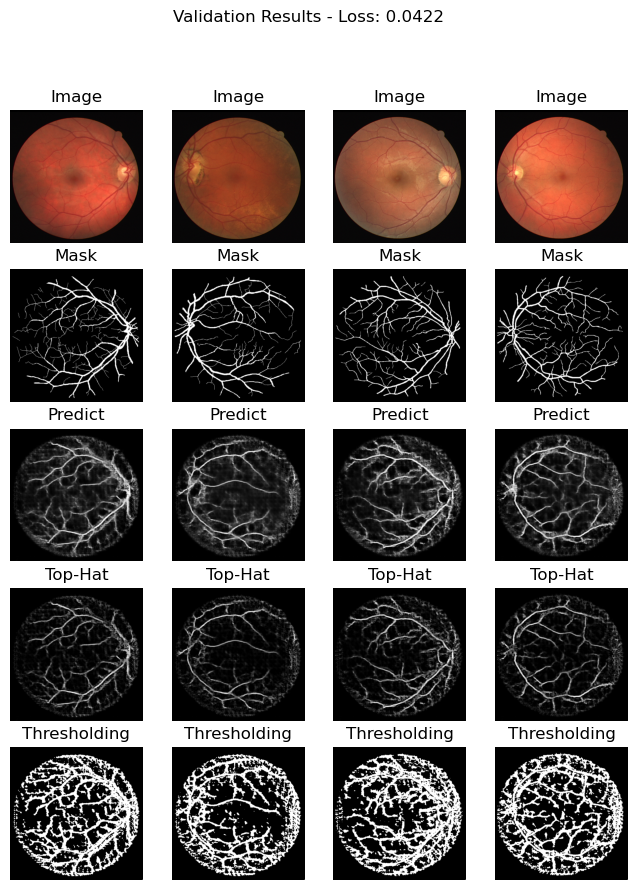

Validation: Loss: 0.0422, Dice: 0.4996, IoU: 0.3330, Acc: 0.9284, Sens: 0.4193, Spec: 0.9759


In [33]:
validate(
    model=model_EncDec,
    loss_fn=focal_loss,
    val_loader=val_loader,
    device=device
)

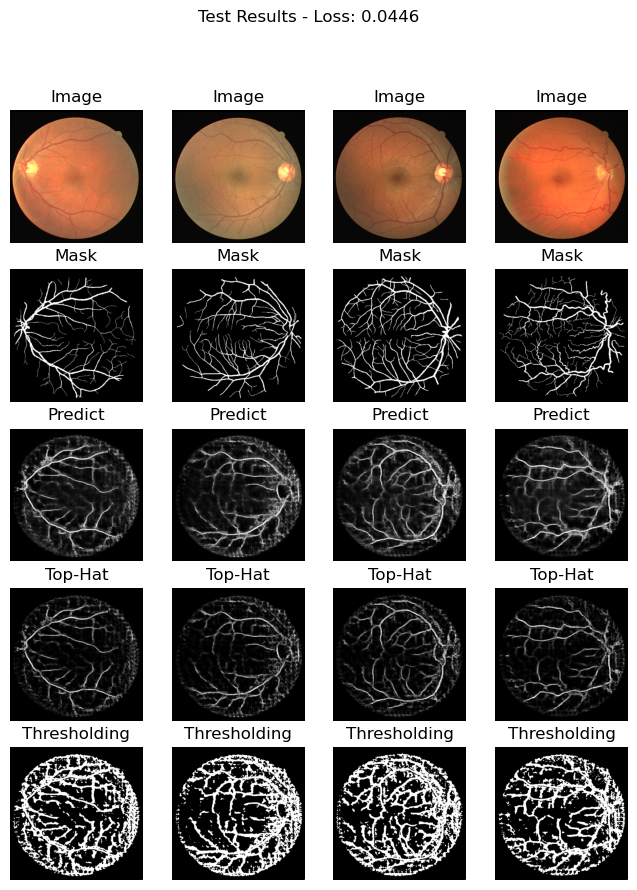

Test Results: Loss: 0.0446, Dice: 0.4677, IoU: 0.3052, Acc: 0.9242, Sens: 0.3707, Spec: 0.9788


In [34]:
test(
    model=model_EncDec,
    loss_fn=focal_loss,
    test_loader=test_loader,
    device=device
)

#### 2. U-Net, without augmentation, epoch=150

In [ ]:
model_UNet = UNet().to(device)
summary(model_UNet, (3, 512, 512))

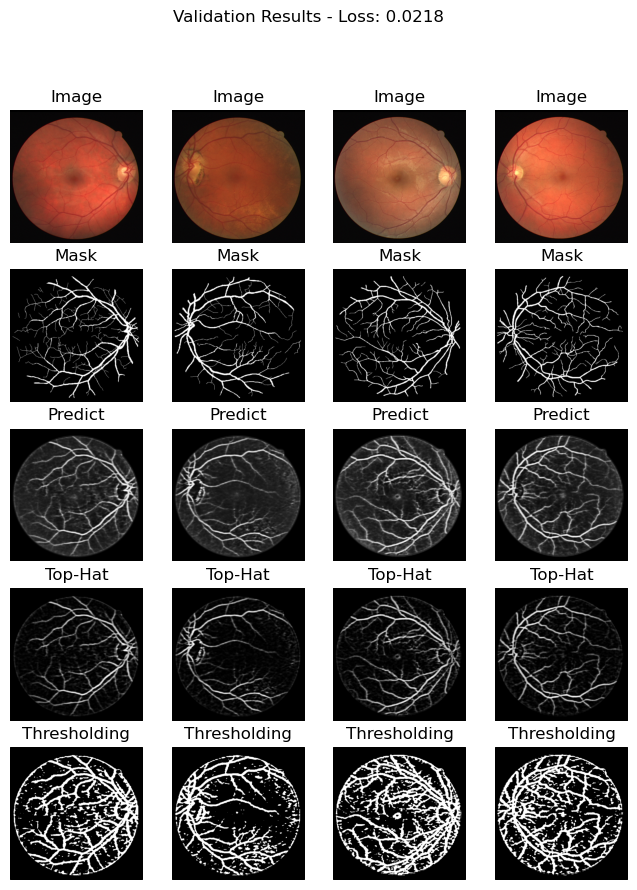

Validation: Loss: 0.0218, Dice: 0.6384, IoU: 0.4688, Acc: 0.9504, Sens: 0.5139, Spec: 0.9911
* Epoch 542/550
 - Training Loss: 0.0212
* Epoch 543/550
 - Training Loss: 0.0212
* Epoch 544/550
 - Training Loss: 0.0212
* Epoch 545/550
 - Training Loss: 0.0211
* Epoch 546/550
 - Training Loss: 0.0210
* Epoch 547/550
 - Training Loss: 0.0209
* Epoch 548/550
 - Training Loss: 0.0208
* Epoch 549/550
 - Training Loss: 0.0208
* Epoch 550/550
 - Training Loss: 0.0209


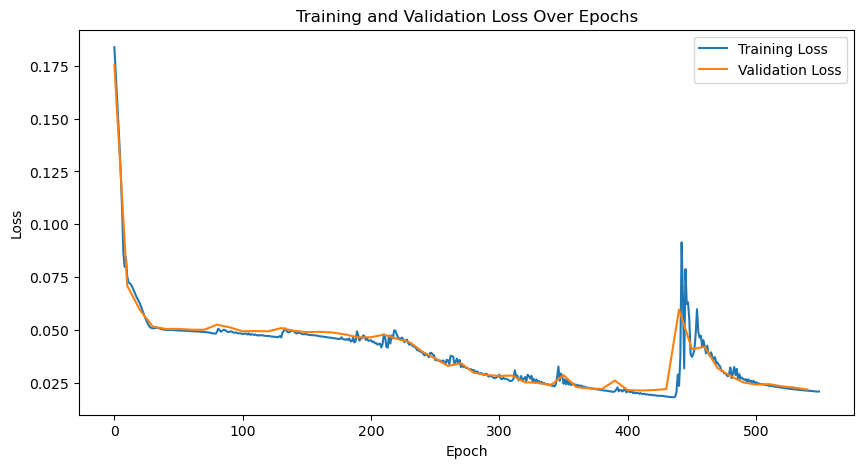

In [63]:
train(
    model=model_UNet,
    opt=optim.Adam(model_UNet.parameters(), lr=0.001),
    # loss_fn=bce_loss,
    loss_fn=focal_loss,
    epochs=550,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device
)

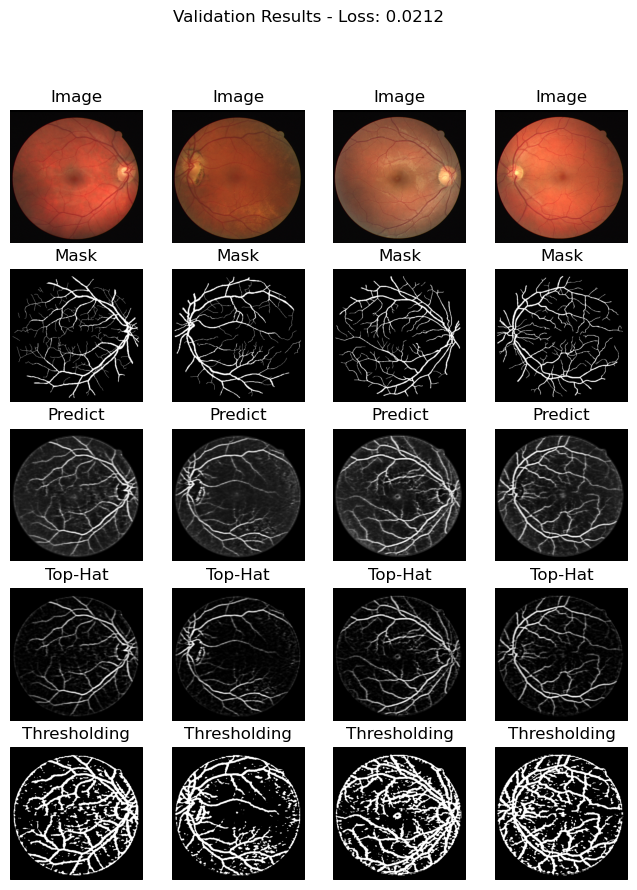

Validation: Loss: 0.0212, Dice: 0.6307, IoU: 0.4606, Acc: 0.9502, Sens: 0.4988, Spec: 0.9923


In [64]:
validate(
    model=model_UNet,
    val_loader=val_loader,
    device=device,
    loss_fn=focal_loss
)

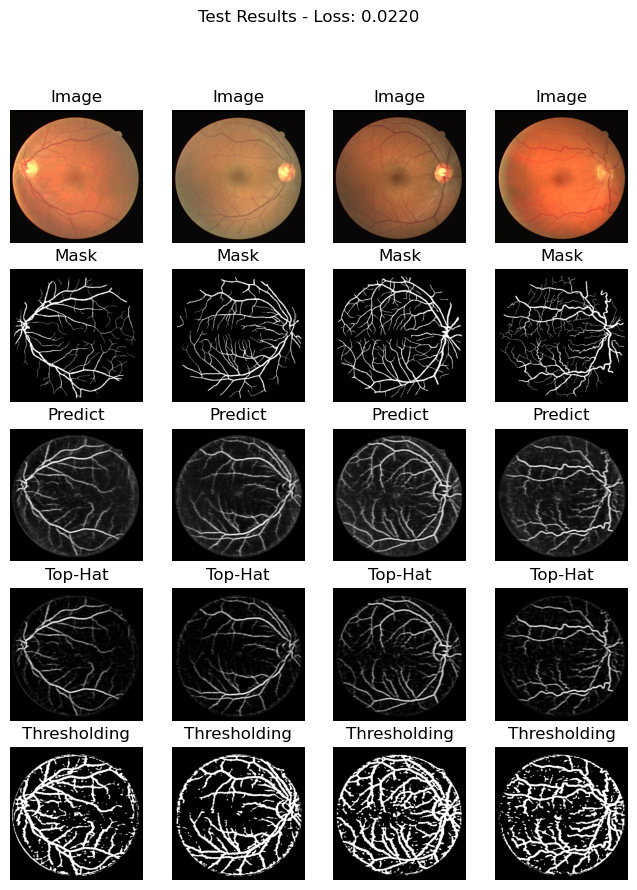

Test Results: Loss: 0.0220, Dice: 0.6023, IoU: 0.4309, Acc: 0.9464, Sens: 0.4513, Spec: 0.9953


In [65]:
test(
    model=model_UNet,
    test_loader=test_loader,
    device=device,
    loss_fn=focal_loss
)

#### 3. U-Net, with augmented data, epoch=150

In [17]:
model_UNet = UNet().to(device)
summary(model_UNet, (3, 512, 512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 512, 512]             448
         MaxPool2d-2         [-1, 16, 256, 256]               0
            Conv2d-3         [-1, 32, 256, 256]           4,640
         MaxPool2d-4         [-1, 32, 128, 128]               0
            Conv2d-5         [-1, 64, 128, 128]          18,496
         MaxPool2d-6           [-1, 64, 64, 64]               0
            Conv2d-7          [-1, 128, 64, 64]          73,856
         MaxPool2d-8          [-1, 128, 32, 32]               0
            Conv2d-9          [-1, 256, 32, 32]         295,168
  ConvTranspose2d-10          [-1, 128, 64, 64]         131,200
           Conv2d-11          [-1, 128, 64, 64]         295,040
  ConvTranspose2d-12         [-1, 64, 128, 128]          32,832
           Conv2d-13         [-1, 64, 128, 128]          73,792
  ConvTranspose2d-14         [-1, 32, 2

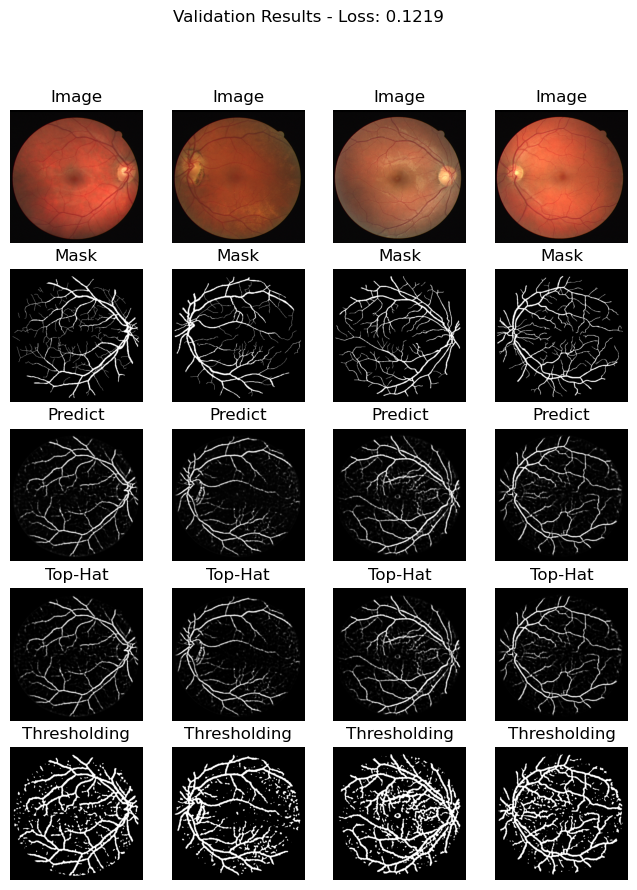

Validation: Loss: 0.1219, Dice: 0.6994, IoU: 0.5377, Acc: 0.9573, Sens: 0.5834, Spec: 0.9921
* Epoch 142/150
 - Training Loss: 0.1346
* Epoch 143/150
 - Training Loss: 0.1294
* Epoch 144/150
 - Training Loss: 0.1292
* Epoch 145/150
 - Training Loss: 0.1342
* Epoch 146/150
 - Training Loss: 0.1341
* Epoch 147/150
 - Training Loss: 0.1340
* Epoch 148/150
 - Training Loss: 0.1316
* Epoch 149/150
 - Training Loss: 0.1299
* Epoch 150/150
 - Training Loss: 0.1271


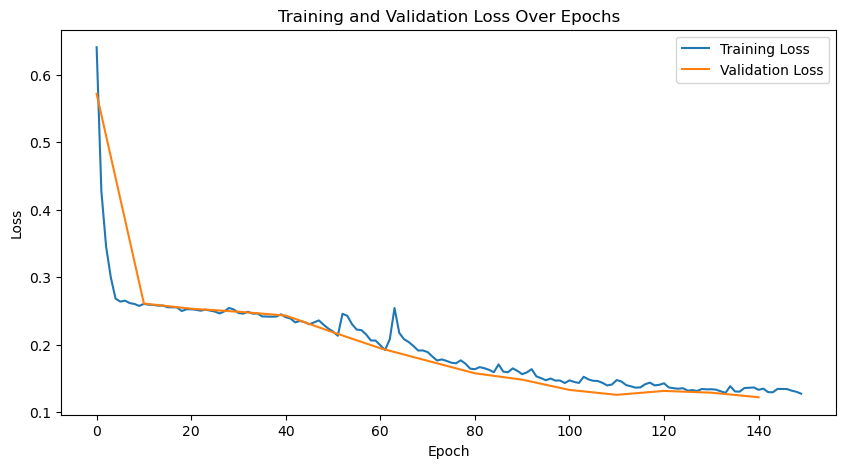

In [18]:
train(
    model=model_UNet,
    opt=optim.Adam(model_UNet.parameters(), lr=0.001),
    loss_fn=bce_loss,
    # loss_fn=focal_loss,
    epochs=150,
    train_loader=aug_train_loader,
    val_loader=val_loader,
    device=device
)

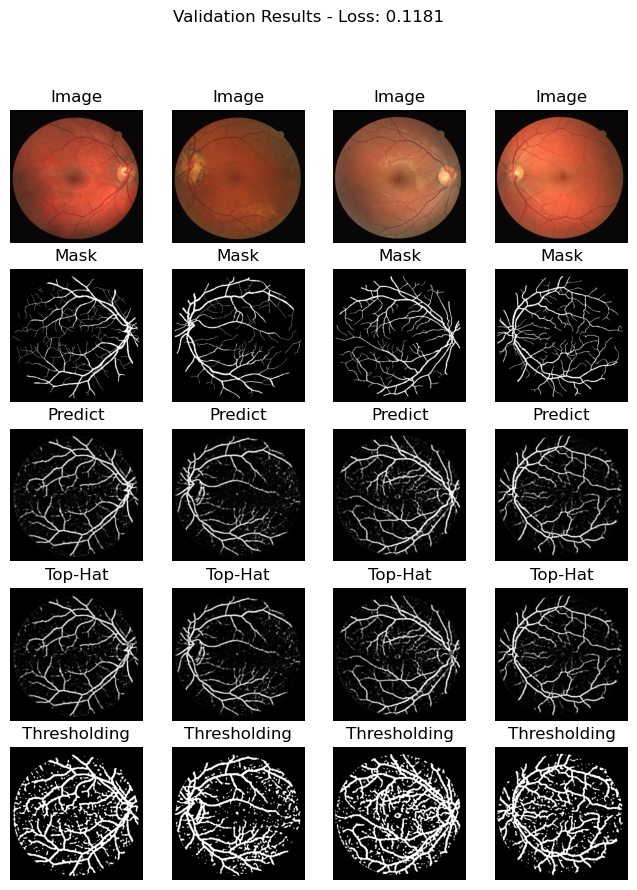

Validation: Loss: 0.1181, Dice: 0.7484, IoU: 0.5979, Acc: 0.9587, Sens: 0.7201, Spec: 0.9810


In [19]:
validate(
    model = model_UNet,
    val_loader=val_loader,
    device = device,
    loss_fn = bce_loss,
)

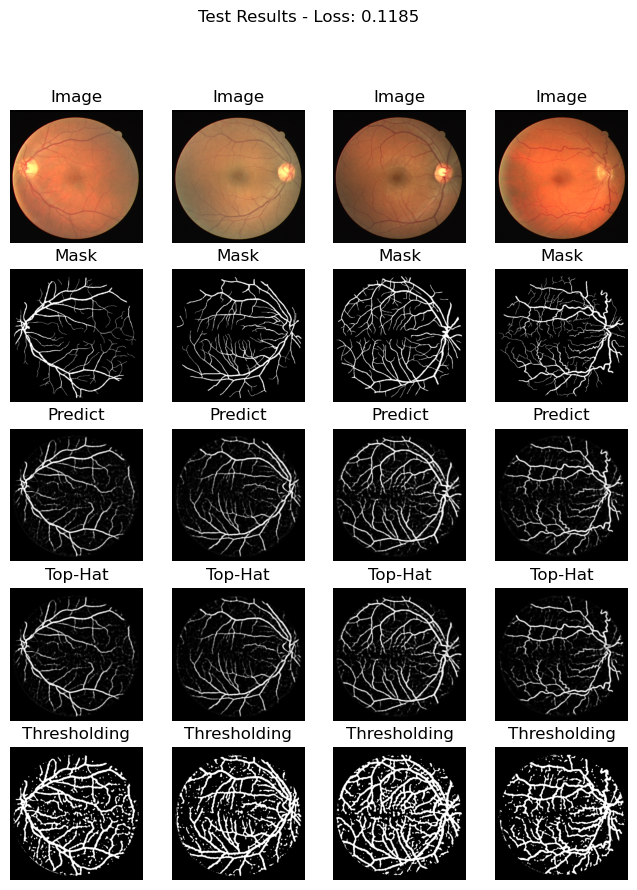

Test Results: Loss: 0.1185, Dice: 0.7390, IoU: 0.5860, Acc: 0.9580, Sens: 0.6618, Spec: 0.9872


In [20]:
test(
    model = model_UNet,
    test_loader=test_loader,
    device = device,
    loss_fn = bce_loss,
)